# 境界条件を伴うカーネル密度推定

## カーネル密度推定と境界
**カーネル密度推定 (kernel density estimation; KDE)** はカーネル関数を用いてデータの確率密度関数を推定する手法である．Pythonの場合は`scipy.stats.gaussian_kde`を使うのが主である．この記事では境界条件があるときにカーネル密度推定をどうすればいいかを扱う．問題を把握するために一様分布$U(-1,1)$からデータをサンプリングして密度推定してみよう．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, uniform

In [2]:
N = 1000
np.random.seed(0)
data_uni = np.random.uniform(-1.0, 1.0, N) # 一様分布からデータ生成

kde_sp = gaussian_kde(data_uni) # KDEのinstance
x_sp= np.arange(-1.5, 1.5, 1e-2) # 密度推定する範囲
pdf_sp = kde_sp(x_sp) # 各xの点における推定した密度

rv_uniform = uniform(-1.0, 2.0)
pdf_uniform = rv_uniform.pdf(x_sp) # 真の確率密度

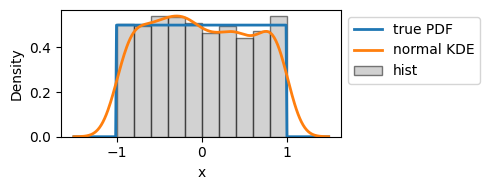

In [3]:
plt.figure(figsize=(5, 2), dpi=100)
plt.plot(x_sp, pdf_uniform, lw=2.0, label="true PDF")
plt.plot(x_sp, pdf_sp, lw=2.0, label="normal KDE")
plt.hist(data_uni, density=True, alpha=0.5, label='hist', color='0.65', edgecolor='k')
plt.xlabel("x"); plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

結果を見るとデータ中央($x=0$)付近の密度推定は概ね上手くいっているが，**境界 ($x=-1,1$) での密度は過小評価**されている．このように境界条件がある場合はどうすればよいかというと，**境界を越えた範囲の推定された密度を反射させる**．篠本先生のWebサイト([Kernel density estimation with reflection boundary](https://s-shinomoto.com/toolbox/reflectedkernel/reflectedkernel.html))の図が大変分かりやすい．

## kalepyを用いた境界反射カーネル密度推定
scipyのカーネル密度推定の関数に境界を設定する機能はない．自前実装は可能だが，車輪の再発明は避けたい．Pythonのパッケージを探すと[kalepy](https://kalepy.readthedocs.io/en/latest/index.html)というものがあった．ということでkalepyを用いた境界反射カーネル密度推定(reflecting KDE)のやり方を紹介する．

### install
まず，installはpipで可能である．

```
pip install kalepy
```

### 1次元データでの基本的な使用法
ライブラリを読み込む．

In [4]:
import kalepy as kale

`kale.density`でカーネル密度推定が可能である．この際，`reflect=True`にすれば最大/最小のデータ点を境界として，反射した密度を推定する．

In [5]:
x_basic, pdf_basic = kale.density(data_uni, probability=True) # 通常
x_reflect, pdf_reflect = kale.density(data_uni, reflect=True, probability=True) # 反射

結果を描画する．`kale.carpet`という関数を使うと生データを下部に描画することができる．

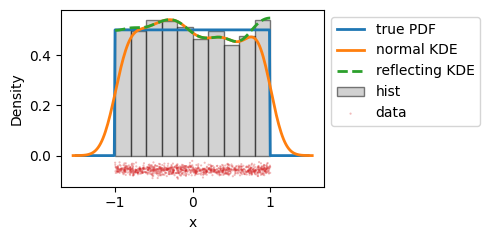

In [6]:
plt.figure(figsize=(5, 2.5), dpi=100)
plt.plot(x_sp, pdf_uniform, lw=2.0, label="true PDF")
plt.plot(x_basic, pdf_basic, lw=2.0, label='normal KDE')
plt.plot(x_reflect, pdf_reflect, "--", lw=2.0, label='reflecting KDE')
plt.hist(data_uni, density=True, alpha=0.5, label='hist', color='0.65', edgecolor='k')
kale.carpet(data_uni, label='data')
plt.xlabel("x"); plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()

### 境界を明示的に設定する場合
明示的に境界を設定することも可能である．例えば$0<x<\infty$で定義される対数正規分布のデータを用いてみよう．

In [7]:
sigma = 1
data_lognorm = np.random.lognormal(sigma=sigma, size=N) # 対数正規分布からデータ生成

以下は下限を0, 上限の設定を無しにした設定である (`reflect=[edge, None]`の部分が該当する)．

In [8]:
edge = 0
x_basic2, pdf_basic2 = kale.density(data_lognorm, probability=True) # 通常
x_reflect2, pdf_reflect2 = kale.density(data_lognorm, reflect=[edge, None], probability=True) # 反射

比較のために実際の対数正規分布の確率密度(pdf)を取得しておこう．

In [9]:
from scipy.stats import lognorm

x_lognorm = np.arange(-1, 20, 1e-2)
rv = lognorm(sigma)

結果を描画する．

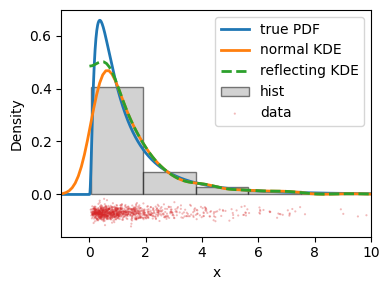

In [10]:
plt.figure(figsize=(4, 3), dpi=100)
plt.plot(x_lognorm, rv.pdf(x_lognorm), lw=2.0, label="true PDF")
plt.plot(x_basic2, pdf_basic2, lw=2.0, label='normal KDE')
plt.plot(x_reflect2, pdf_reflect2, "--", lw=2.0, label='reflecting KDE')
plt.hist(data_lognorm, density=True, alpha=0.5, label='hist', color='0.65', edgecolor='k')
kale.carpet(data_lognorm, label='data')
plt.xlabel("x"); plt.ylabel("Density")
plt.xlim(-1, 10)
plt.legend()
plt.tight_layout()

### 2次元データの場合
データをライブラリ内のtoyデータ生成関数を用いて生成する．

In [11]:
data = kale.utils._random_data_2d_03(num=1e3)

2次元の場合は`kale.KDE`を用いる．

In [12]:
kde = kale.KDE(data, reflect=[[0, None], [None, 1]])

結果を描画する．`kale.dist2d`を用いるとよい．

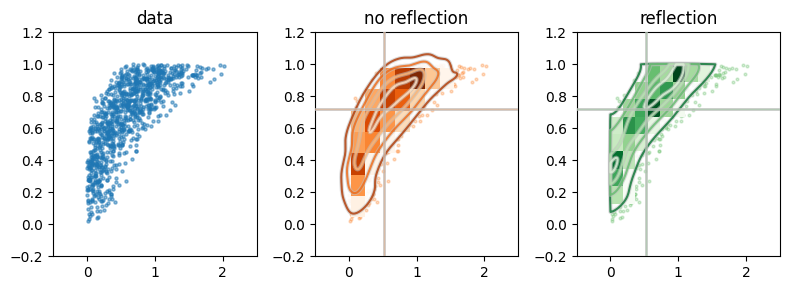

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=100)

axes[0].scatter(data[0], data[1], s=5, alpha=0.5)
kale.dist2d(data, ax=axes[1], cmap='Oranges') # 反射なし
kale.dist2d(kde, ax=axes[2], cmap='Greens') # 反射あり

titles = ['data', 'no reflection', 'reflection']
for ax, title in zip(axes, titles):
    ax.set(xlim=[-0.5, 2.5], ylim=[-0.2, 1.2], title=title)
fig.tight_layout()

`kale.corner`という各軸の密度を同時に描画する関数も用意されている．

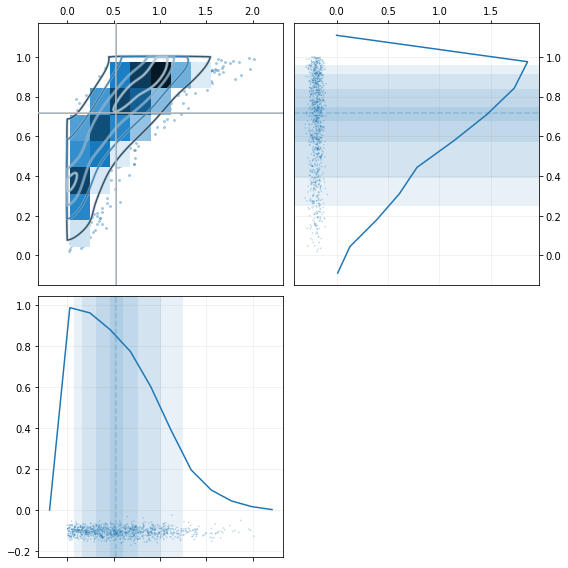

In [14]:
kale.corner(kde)
plt.tight_layout()

## まとめ
- 境界条件を伴うカーネル密度推定をする場合は境界で密度を反射させる．
- kalepyを用いると上記の実装がやりやすい．